### Problem Statement and Goal of Project

This project addresses the uncertainty faced by farmers regarding seasonal crop yield by developing a machine learning-based prediction system. 

Using key input features: average temperature, total rainfall, and pesticide quantity, the system performs two tasks: classification and regression.

For classification, the yield is categorized into low, average, and high using Random Forest Classifier, Gradient Boosting Classifier, and XGBoost Classifier.

For regression, Linear Regression is applied to predict the actual yield value, providing a quantitative estimate.

The dataset is cleaned and exploratory data analysis is done, including handling missing values, feature scaling, and correlation analysis.

**This is a generalized crop yield prediction model that estimates yield based only on climate and pesticide input levels. It assumes an average crop profile and region.**

##### Requirements:
Run "!pip install xgboost" before training with XGBoost classifier

In [43]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Collection

In [158]:
df_pesticides = pd.read_csv("Dataset/pesticides.csv")
df_rainfall = pd.read_csv("Dataset/rainfall.csv")
df_temp = pd.read_csv("Dataset/temp.csv")
df_yield = pd.read_csv("Dataset/yield.csv")
# Final dataset already available by cleaning and merging of pesticides, rainfall, temp, yield. 
df_yield_df = pd.read_csv("Dataset/yield_df.csv")

#### Data Cleaning and Merging
Though, the dataset already has this file but for the learning purpose, we're doing this step. 

In [159]:
for name, df in zip(["Pesticides", "Rainfall", "Temperature", "Yield"],
                    [df_pesticides, df_rainfall, df_temp, df_yield]):
    print(f"{name} dataset shape: {df.shape}")

Pesticides dataset shape: (4349, 7)
,Rainfall dataset shape: (6727, 3)
,Temperature dataset shape: (71311, 3)
,Yield dataset shape: (56717, 12)


In [160]:
# Check for Null values, invalid and missing enteries
for name, df in zip(["Pesticides", "Rainfall", "Temperature", "Yield"],
                    [df_pesticides, df_rainfall, df_temp, df_yield]):
    print(f"\nDataset: {name}")
    total_rows = len(df)
    
    # Null values
    null_counts = df.isnull().sum()
    null_percent = (null_counts / total_rows) * 100
    null_info = pd.DataFrame({'Null Count': null_counts, 'Null %': null_percent})
    null_info = null_info[null_info['Null Count'] > 0]
    
    # Invalid values ("?")
    invalid_counts = (df == "?").sum()
    invalid_percent = (invalid_counts / total_rows) * 100
    invalid_info = pd.DataFrame({'Invalid Count': invalid_counts, 'Invalid %': invalid_percent})
    invalid_info = invalid_info[invalid_info['Invalid Count'] > 0]

    if not null_info.empty:
        print("Columns with null values:")
        print(null_info.round(2))
    else:
        print("No null values.")
    
    if not invalid_info.empty:
        print("Columns with '?' invalid values:")
        print(invalid_info.round(2))
    else:
        print("No '?' invalid values.")


,Dataset: Pesticides
,No null values.
,No '?' invalid values.
,
,Dataset: Rainfall
,Columns with null values:
,                               Null Count  Null %
,average_rain_fall_mm_per_year         774   11.51
,No '?' invalid values.
,
,Dataset: Temperature
,Columns with null values:
,          Null Count  Null %
,avg_temp        2547    3.57
,No '?' invalid values.
,
,Dataset: Yield
,No null values.
,No '?' invalid values.


In Dataset Rainfall and Temperature, 11.5 % and 3.57 % Null Values are found respectively. We can drop because of low percentage. There are no Invalid enteries

In [161]:
# Common cleaning for each file
for df in [df_temp]:
    df.dropna(inplace=True)

In [162]:
#df_rainfall.isnull().sum().any()
df_temp.isnull().sum().any()

False

In [74]:
df_rainfall.columns

Index([' Area', 'Year', 'average_rain_fall_mm_per_year'], dtype='object')

In [163]:
df_rainfall.rename(columns={' Area': 'Area'}, inplace=True)

In [164]:
df_rainfall['average_rain_fall_mm_per_year'].isnull().groupby(df_rainfall['Area']).sum()
df_rainfall['average_rain_fall_mm_per_year'].isnull().groupby(df_rainfall['Year']).sum()

Year
1985    24
1986    25
1987    25
1989    25
1990    25
1991    25
1992    25
1993    25
1994    25
1995    25
1996    25
1997    25
1998    25
1999    25
2000    25
2001    25
2002    25
2004    25
2005    25
2006    25
2007    25
2008    25
2009    25
2010    25
2011    25
2012    25
2013    25
2014    25
2015    25
2016    25
2017    25
Name: average_rain_fall_mm_per_year, dtype: int64

This output shows exactly which years contain missing rainfall data.
In 1985, there are 24 missing values.
From 1986–2017, there are 25 missing values per year (except 1985 and 1988, which may be different or missing entirely from the list).

In [165]:

# Replace '..' with np.nan
df_rainfall['average_rain_fall_mm_per_year'] = df_rainfall['average_rain_fall_mm_per_year'].replace('..', np.nan)


In [166]:
# Remove any extra spaces or unwanted characters
df_rainfall['average_rain_fall_mm_per_year'] = df_rainfall['average_rain_fall_mm_per_year']\
    .astype(str).str.replace(r'[^\d\.]', '', regex=True).str.strip()

# Convert to float
df_rainfall['average_rain_fall_mm_per_year'] = pd.to_numeric(
    df_rainfall['average_rain_fall_mm_per_year'], errors='coerce'
)

In [167]:
print("Missing values after cleaning:", df_rainfall['average_rain_fall_mm_per_year'].isnull().sum())


Missing values after cleaning: 780


In [168]:
# Area + Year
df_rainfall['average_rain_fall_mm_per_year'] = df_rainfall.groupby(['Area', 'Year'])['average_rain_fall_mm_per_year']\
    .transform(lambda x: x.fillna(x.mean()))

# Area fallback
df_rainfall['average_rain_fall_mm_per_year'] = df_rainfall.groupby('Area')['average_rain_fall_mm_per_year']\
    .transform(lambda x: x.fillna(x.mean()))

# Global fallback
df_rainfall['average_rain_fall_mm_per_year'] = df_rainfall['average_rain_fall_mm_per_year']\
    .fillna(df_rainfall['average_rain_fall_mm_per_year'].mean())

In [169]:
print("Missing values after imputation:", df_rainfall['average_rain_fall_mm_per_year'].isnull().sum())

Missing values after imputation: 0


In [170]:
print(df_rainfall['average_rain_fall_mm_per_year'].dtype)

float64


In [180]:
# Selection of required features for required result and renaming common columns
# rainfall.csv
rainfall_selected = df_rainfall[['Area', 'Year','average_rain_fall_mm_per_year']].rename(columns={'Area':'Area'})

# temperature.csv
temperature_selected = df_temp[['country', 'year', 'avg_temp']].rename(
    columns={'country': 'Area', 'year':'Year'})

# pesticides.csv
pesticide_selected = df_pesticides[['Area', 'Year', 'Value']].rename(
    columns={ 'Value':'Pesticide Quantity(Tonnes of Active Ingredients'})

# yield_df.csv
yield_selected = df_yield[['Area', 'Year', 'Item', 'Value']].rename(columns={'item':'Crop Type', "Value":'Yield (hg/ha)'})

Data files are merged using inner join because we only need observations where all the columns are matching.

In [181]:
# Merging Dataframes sequentially
# Step 1: merge yield with rainfall
merged_df = pd.merge(yield_selected,rainfall_selected, on=['Area', 'Year'], how='inner')

# Step 2: merge with temperature
merged_df = pd.merge(merged_df, temperature_selected, on=['Area', 'Year'], how='inner')

# Step 3: merge with pesticides
merged_df = pd.merge(merged_df, pesticide_selected, on=['Area', 'Year'], how='inner')

In [182]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 28248 entries, 0 to 28247
,Data columns (total 7 columns):
, #   Column                                           Non-Null Count  Dtype  
,---  ------                                           --------------  -----  
, 0   Area                                             28248 non-null  object 
, 1   Year                                             28248 non-null  int64  
, 2   Item                                             28248 non-null  object 
, 3   Yield (hg/ha)                                    28248 non-null  int64  
, 4   average_rain_fall_mm_per_year                    28248 non-null  float64
, 5   avg_temp                                         28248 non-null  float64
, 6   Pesticide Quantity(Tonnes of Active Ingredients  28248 non-null  float64
,dtypes: float64(3), int64(2), object(2)
,memory usage: 1.5+ MB


In [175]:
print("Final merged shape:", merged_df.shape)
print("Missing values:\n", merged_df.isnull().sum())

Final merged shape: (28248, 7)
,Missing values:
, Area                                               0
,Year                                               0
,Item                                               0
,Yield (hg/ha)                                      0
,average_rain_fall_mm_per_year                      0
,avg_temp                                           0
,Pesticide Quantity(Tonnes of Active Ingredients    0
,dtype: int64


#### Analysis of Our cleaned file with the already existing one

In [92]:
def compare_columns(df1, df2):
    return {
        "common_columns": list(set(df1.columns) & set(df2.columns)),
        "only_in_df1": list(set(df1.columns) - set(df2.columns)),
        "only_in_df2": list(set(df2.columns) - set(df1.columns))
    }

compare_columns(merged_df, df_yield_df)

{'common_columns': ['average_rain_fall_mm_per_year',
  'Item',
  'avg_temp',
  'Area',
  'Year'],
 'only_in_df1': ['Yield (hg/ha)',
  'Pesticide Quantity(Tonnes of Active Ingredients'],
 'only_in_df2': ['hg/ha_yield', 'Unnamed: 0', 'pesticides_tonnes']}

In [93]:
print("Shape of merged_df:", merged_df.shape)
print("Shape of yield_df:", df_yield_df.shape)

print("Duplicates in merged_df:", merged_df.duplicated(subset=['Area', 'Year']).sum())
print("Duplicates in yield_df:", df_yield_df.duplicated(subset=['Area', 'Year']).sum())


Shape of merged_df: (28248, 7)
,Shape of yield_df: (28242, 8)
,Duplicates in merged_df: 25996
,Duplicates in yield_df: 25992


In [98]:
# Count how many times each (area, year) pair appears
dup_counts = merged_df.groupby(['Area', 'Year']).size().reset_index(name='count')

# Filter only duplicates (where count > 1)
dup_summary = dup_counts[dup_counts['count'] > 1].sort_values(by='count', ascending=False)

print("Duplicates per (Area, Year):")
print(dup_summary.info())

Duplicates per (Area, Year):
,<class 'pandas.core.frame.DataFrame'>
,Index: 2235 entries, 951 to 1988
,Data columns (total 3 columns):
, #   Column  Non-Null Count  Dtype 
,---  ------  --------------  ----- 
, 0   Area    2235 non-null   object
, 1   Year    2235 non-null   int64 
, 2   count   2235 non-null   int64 
,dtypes: int64(2), object(1)
,memory usage: 69.8+ KB
,None


In [100]:
# check if duplicates are due to multiple crops
# Check how many unique crops exist per (area, year)
crop_per_area_year = merged_df.groupby(['Area', 'Year'])['Item'].nunique().reset_index(name='num_crops')

# Keep only where more than 1 crop exists per (area, year)
multi_crop_entries = crop_per_area_year[crop_per_area_year['num_crops'] > 1]

print("Area-Year combinations with multiple crops:")
print(multi_crop_entries.head())

Area-Year combinations with multiple crops:
,      Area  Year  num_crops
,0  Albania  1990          6
,1  Albania  1991          6
,2  Albania  1992          6
,3  Albania  1993          5
,4  Albania  1994          4


#####  these are multi-crop records, as we have multiple rows per (Area, Year) because each row corresponds to a different crop.

In [104]:
# 1. Check exact duplicates (same area, year, crop, and yield)
exact_dupes = merged_df.duplicated(subset=['Area', 'Year', 'Item', 'Yield (hg/ha)','average_rain_fall_mm_per_year','avg_temp','Pesticide Quantity(Tonnes of Active Ingredients'])
print(f"Exact duplicates: {exact_dupes.sum()}")

# 2. Check conflicting yield records for same area, year, crop
conflicts = merged_df.duplicated(subset=['Area', 'Year', 'Item'], keep=False)
conflicting_rows = merged_df[conflicts].sort_values(['Area', 'Year', 'Item'])


Exact duplicates: 2310


In [105]:
merged_df = merged_df.drop_duplicates(subset=['Area', 'Year', 'Item', 'Yield (hg/ha)', 'average_rain_fall_mm_per_year', 'avg_temp', 'Pesticide Quantity(Tonnes of Active Ingredients'])
merged_df.reset_index(drop=True, inplace=True)

In [108]:
print(merged_df.isnull().sum())
print("Total duplicate rows:", df_yield_df.duplicated().sum())

Area                                               0
,Year                                               0
,Item                                               0
,Yield (hg/ha)                                      0
,average_rain_fall_mm_per_year                      0
,avg_temp                                           0
,Pesticide Quantity(Tonnes of Active Ingredients    0
,dtype: int64
,Total duplicate rows: 0


In [123]:
def check_yield(area, year, crop, df):
    result = df[
        (df['Area'] == area) &
        (df['Year'] == year) &
        (df['Item'] == crop)
    ][['Area', 'Year', 'Item', 'Yield (hg/ha)', 
       'average_rain_fall_mm_per_year', 'avg_temp', 
       'Pesticide Quantity(Tonnes of Active Ingredients']]

    if result.empty:
        print("No data found for the given input.")
    else:
        print(result)
check_yield("Albania", 1991, "Maize", merged_df)

      Area  Year   Item  Yield (hg/ha)  average_rain_fall_mm_per_year  \
,1  Albania  1991  Maize          29068                         1485.0   
,
,   avg_temp  Pesticide Quantity(Tonnes of Active Ingredients  
,1     15.36                                            121.0  


In [125]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
,Index: 68764 entries, 0 to 71310
,Data columns (total 3 columns):
, #   Column    Non-Null Count  Dtype  
,---  ------    --------------  -----  
, 0   year      68764 non-null  int64  
, 1   country   68764 non-null  object 
, 2   avg_temp  68764 non-null  float64
,dtypes: float64(1), int64(1), object(1)
,memory usage: 2.1+ MB


In [132]:
df_originalyield = df_yield[
    (df_yield['Area'] == 'Albania') &
    (df_yield['Year'] == 1991) &
    (df_yield['Item'] == 'Maize')
][['Area', 'Year', 'Item', 'Value']]  
print(df_originalyield)

        Area  Year   Item  Value
,254  Albania  1991  Maize  29068


In [133]:
df_originalrain = df_rainfall[
    (df_rainfall['Area'] == 'Albania') &
    (df_rainfall['Year'] == 1991)
][['Area', 'Year', 'average_rain_fall_mm_per_year']]
print(df_originalrain)

       Area  Year  average_rain_fall_mm_per_year
,36  Albania  1991                         1485.0


In [134]:
df_originaltemp = df_temp[
    (df_temp['country'] == 'Albania') &
    (df_temp['year'] == 1991)
][['country', 'year', 'avg_temp']]
print(df_originaltemp)

       country  year  avg_temp
,64386  Albania  1991     15.36


In [135]:
df_originalpest = df_pesticides[
    (df_pesticides['Area'] == 'Albania') &
    (df_pesticides['Year'] == 1991)
][['Area', 'Year', 'Value']]  
print(df_originalpest)

      Area  Year  Value
,1  Albania  1991  121.0


### Data Visualization, Analysis and Interpretation
Check for desciption
check outliers
check 

In [282]:
print(merged_df.describe())
print(merged_df.info())

               Year  Yield (hg/ha)  average_rain_fall_mm_per_year  \
,count  28248.000000   28248.000000                    28242.00000   
,mean    2001.541950   77047.863282                     1149.05598   
,std        7.052997   84950.194454                      709.81215   
,min     1990.000000      50.000000                       51.00000   
,25%     1995.000000   19918.750000                      593.00000   
,50%     2001.000000   38295.000000                     1083.00000   
,75%     2008.000000  104598.250000                     1668.00000   
,max     2013.000000  501412.000000                     3240.00000   
,
,           avg_temp  Pesticide Quantity(Tonnes of Active Ingredients  
,count  28248.000000                                     28248.000000  
,mean      20.543722                                     37069.136973  
,std        6.311828                                     59954.787836  
,min        1.300000                                         0.040000  
,25%     

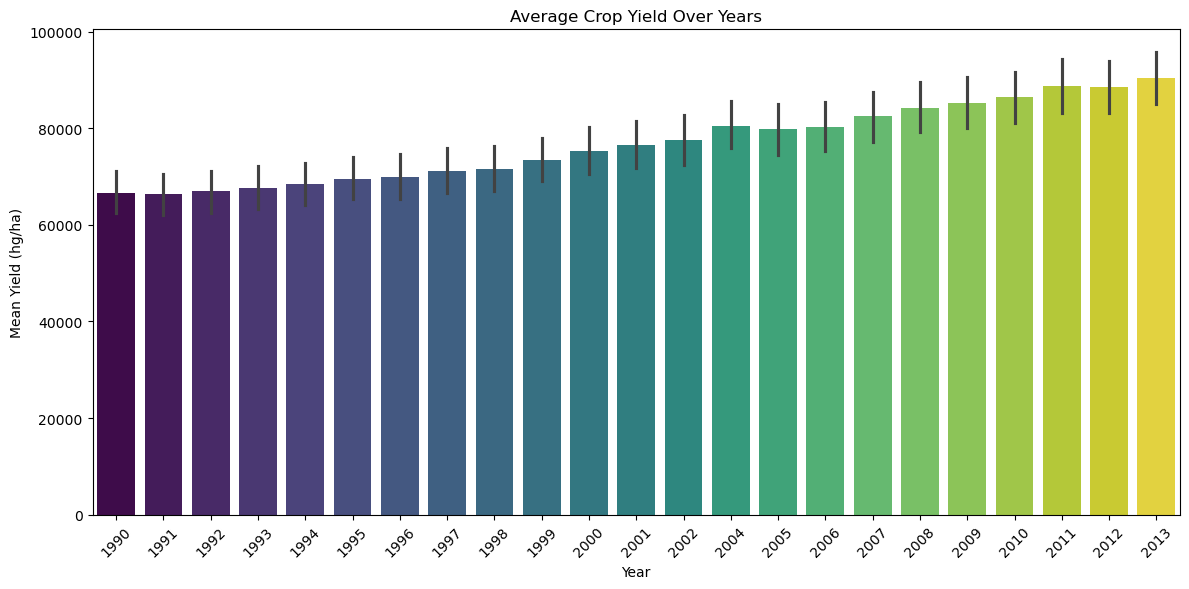

In [136]:
#Average Yield per Year
plt.figure(figsize=(12, 6))
sns.barplot(
    data=merged_df,
    x='Year',
    y='Yield (hg/ha)',
    estimator='mean',
    hue='Year', 
    palette='viridis',
    legend=False
)
plt.title('Average Crop Yield Over Years')
plt.xlabel('Year')
plt.ylabel('Mean Yield (hg/ha)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

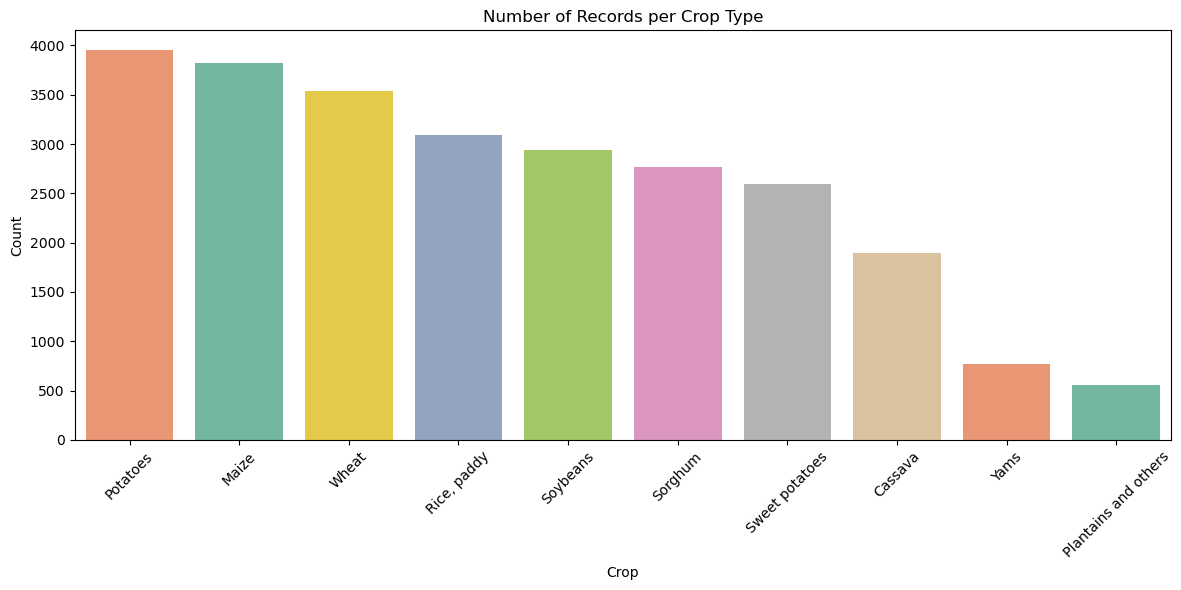

In [138]:
#Count of Records per Crop
plt.figure(figsize=(12, 6))
sns.countplot(
    data=merged_df,
    x='Item',
    order=merged_df['Item'].value_counts().index,
    hue='Item',        
    palette='Set2',
    legend=False        
)
plt.xticks(rotation=45)
plt.title('Number of Records per Crop Type')
plt.xlabel('Crop')
plt.ylabel('Count')
plt.tight_layout()
plt.show() 

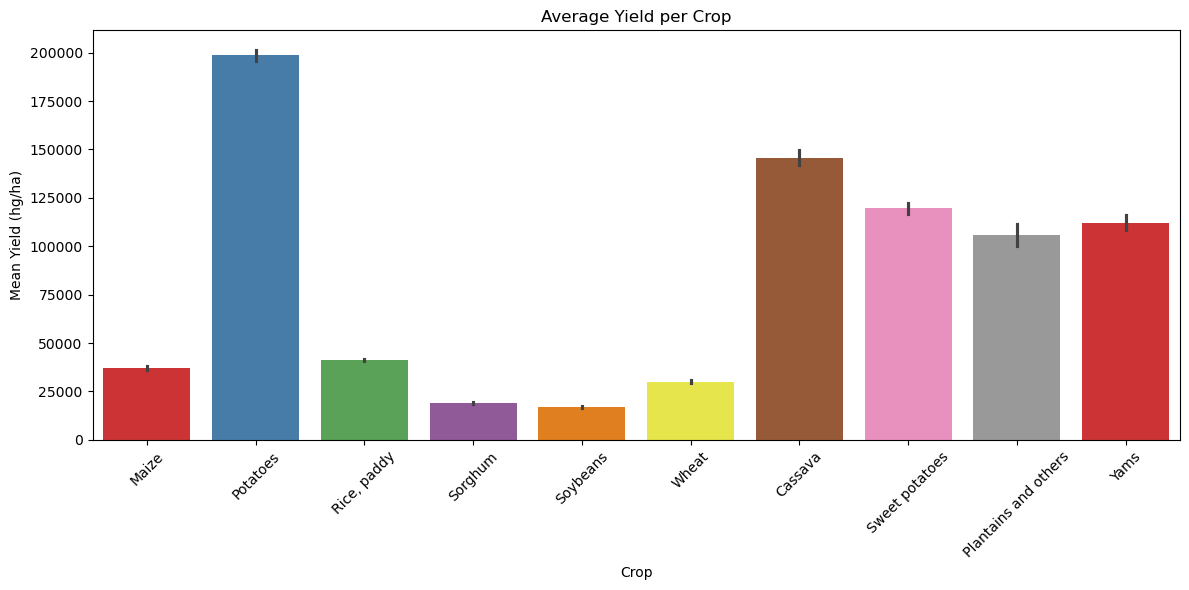

In [139]:
#Average Yield per Crop
plt.figure(figsize=(12, 6))
sns.barplot(
    data=merged_df,
    x='Item',
    y='Yield (hg/ha)',
    estimator='mean',
    hue='Item',      
    palette='Set1',
    legend=False      
)
plt.xticks(rotation=45)
plt.title('Average Yield per Crop')
plt.xlabel('Crop')
plt.ylabel('Mean Yield (hg/ha)')
plt.tight_layout()
plt.show()

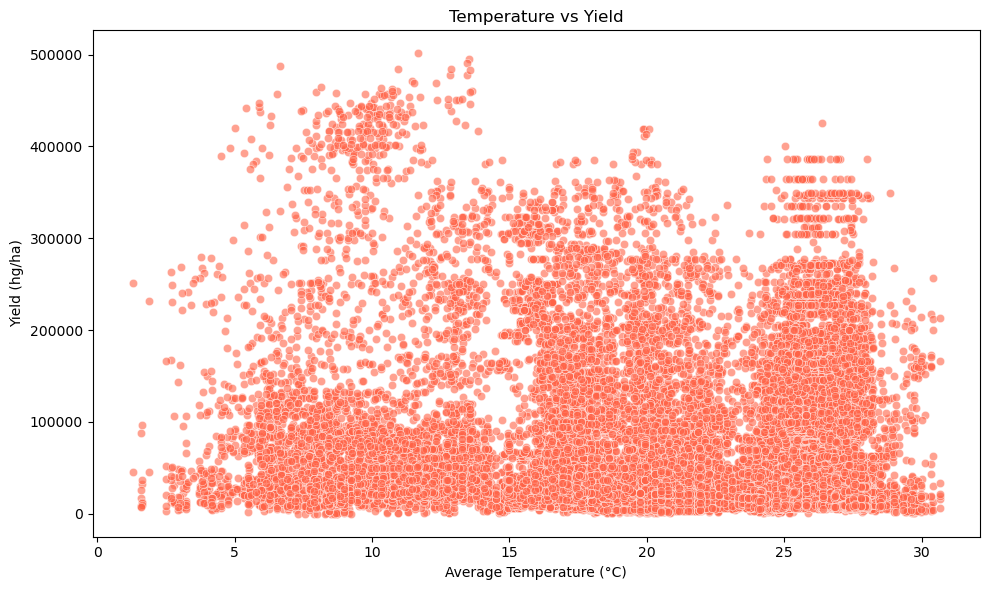

In [140]:
#Temperature vs Yield (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='avg_temp', y='Yield (hg/ha)', alpha=0.6, color='tomato')
plt.title('Temperature vs Yield')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Yield (hg/ha)')
plt.tight_layout()
plt.show() 

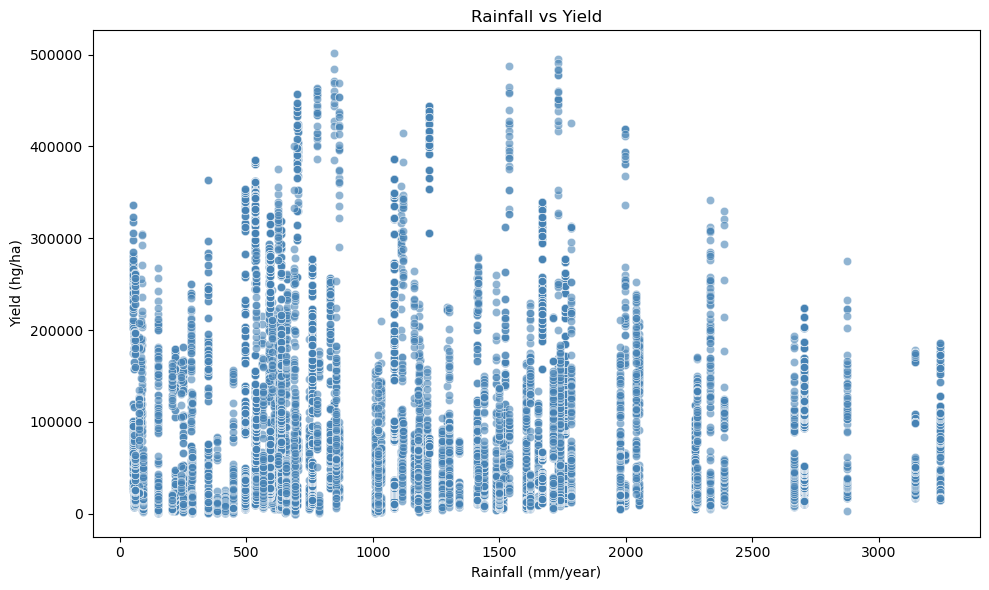

In [141]:
#Rainfall vs Yield
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='average_rain_fall_mm_per_year', y='Yield (hg/ha)', alpha=0.6, color='steelblue')
plt.title('Rainfall vs Yield')
plt.xlabel('Rainfall (mm/year)')
plt.ylabel('Yield (hg/ha)')
plt.tight_layout()
plt.show()  

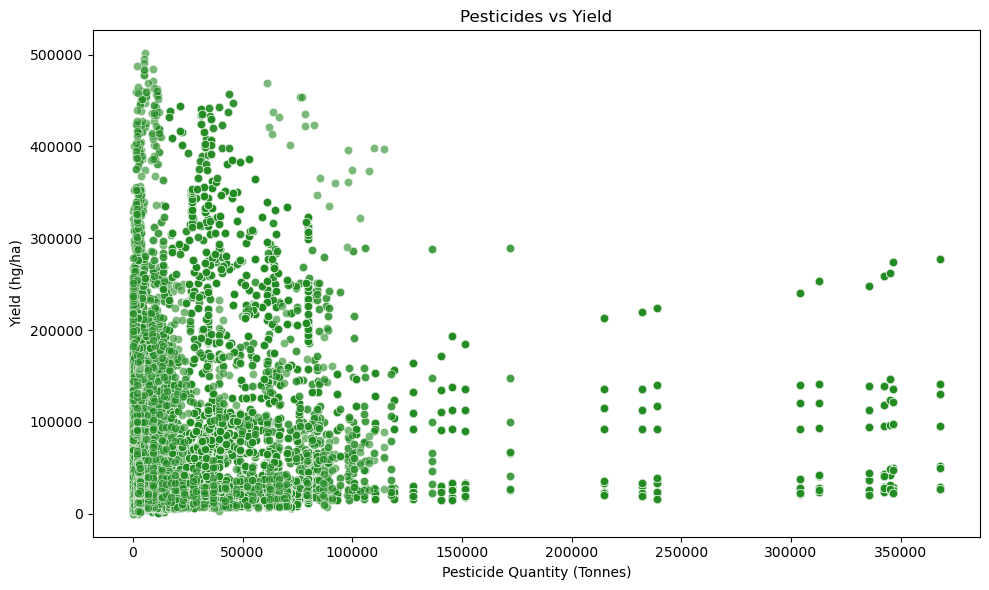

In [142]:
#Pesticides vs Yield (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Pesticide Quantity(Tonnes of Active Ingredients', y='Yield (hg/ha)', alpha=0.6, color='forestgreen')
plt.title('Pesticides vs Yield')
plt.xlabel('Pesticide Quantity (Tonnes)')
plt.ylabel('Yield (hg/ha)')
plt.tight_layout()
plt.show()

<Axes: xlabel='Yield (hg/ha)', ylabel='Count'>

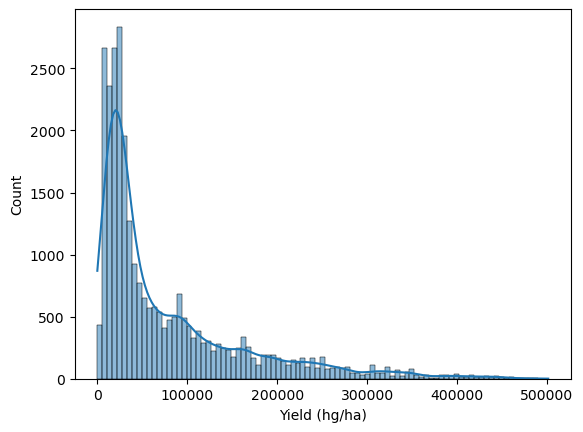

In [312]:
sns.histplot(merged_df['Yield (hg/ha)'], kde=True)

##### We have more yield from range of 10k-20k.  

<Axes: xlabel='Yield (hg/ha)'>

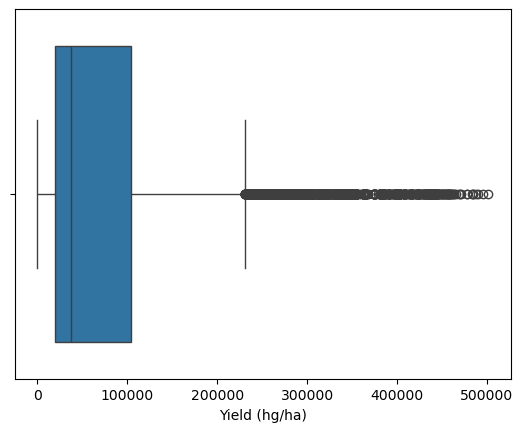

In [68]:
# Detection of outliers
sns.boxplot(x='Yield (hg/ha)', data=merged_df)

##### There are outliers from the range of 30000-50000 yield but we are using Random Tree Forest which is less sensitive to outliers so keeping them

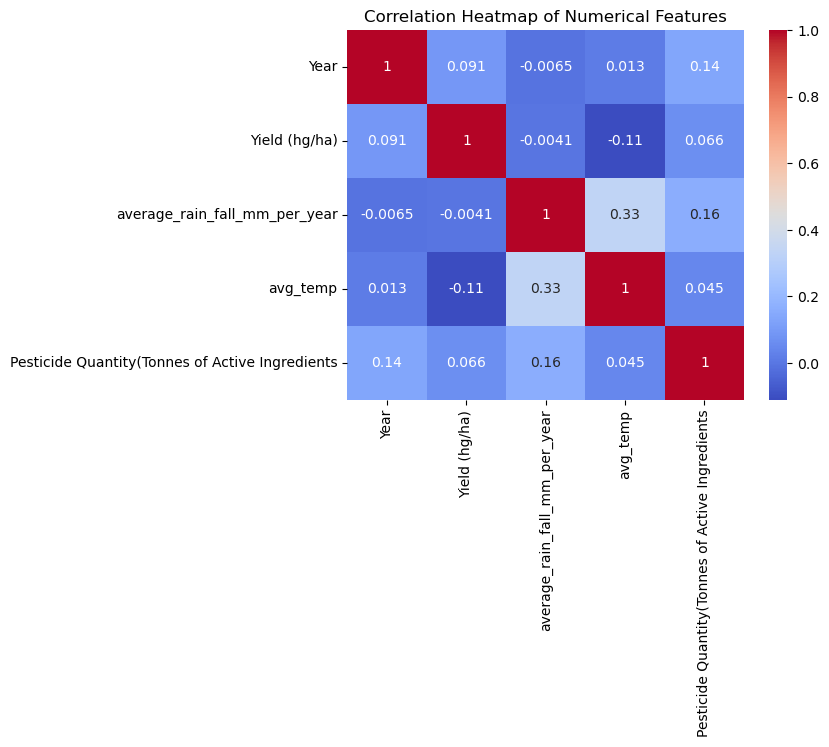

In [143]:
# Checking correlation among features
numeric_df = merged_df.select_dtypes(include=['number'])

# Plot heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

##### The correlation values all around 0 shows no correlation among features

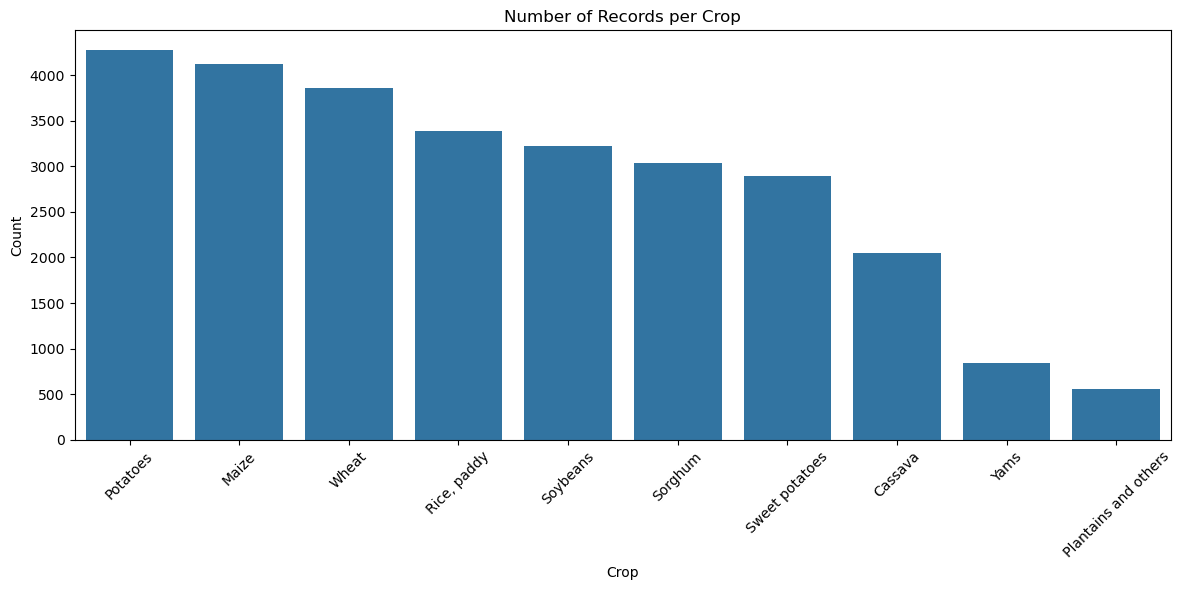

In [55]:
# Analysis on what types of crops we have
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_df, x='Item', order=merged_df['Item'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Number of Records per Crop')
plt.xlabel('Crop')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Crop Rice and Paddy maybe the same crop so renaming Paddy.
"Plantains and others" are vague crops that may not be useful so dropping it

In [144]:
merged_df['Item'] = merged_df['Item'].str.replace('paddy','Rice')
merged_df = merged_df[merged_df['Item'] != 'Plantains and others']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7116\3305235049.py:1: SettingWithCopyWarning: 
,A value is trying to be set on a copy of a slice from a DataFrame.
,Try using .loc[row_indexer,col_indexer] = value instead
,
,See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
,  merged_df['Item'] = merged_df['Item'].str.replace('paddy','Rice')


In [145]:
merged_df['Item'].value_counts()

Item
Potatoes          3956
Maize             3826
Wheat             3539
Rice, Rice        3091
Soybeans          2940
Sorghum           2770
Sweet potatoes    2595
Cassava           1891
Yams               774
Name: count, dtype: int64

In [157]:
# Renaming input features for better ease of use
merged_df = merged_df.rename(columns={'average_rain_fall_mm_per_year':'rainfall','Pesticide Quantity(Tonnes of Active Ingredients':'pesticides','avg_temp':'temperature'})
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
,Index: 22849 entries, 0 to 25937
,Data columns (total 8 columns):
, #   Column         Non-Null Count  Dtype  
,---  ------         --------------  -----  
, 0   Area           22849 non-null  object 
, 1   Year           22849 non-null  int64  
, 2   Item           22849 non-null  object 
, 3   Yield (hg/ha)  22849 non-null  int64  
, 4   rainfall       22849 non-null  float64
, 5   temperature    22849 non-null  float64
, 6   pesticides     22849 non-null  float64
, 7   Yield_Class    22849 non-null  object 
,dtypes: float64(3), int64(2), object(3)
,memory usage: 2.1+ MB


### Explanation of Feature Engineering, algorithm and Model Selection
Our Goal is to classify whether yield in a given season will be below-average, average, or above-average. We are using Classification algorithm. We need Classes of yield **"Low, average, high"**. The yield feature is a numerical variable and continuous. In feature Enggineering step, we convert it into categorical feature

### Feature-Target Split
- X ( input features ) -> Rainfall, Temperture, Pesticides
- Y ( Target Feature ) -> Yield

#### The correlation values tell there is no particular linear relationship between variables 

In [185]:
# Feature Engineering:
def yield_category(y):
    if y < merged_df['Yield (hg/ha)'].quantile(0.33):
        return 'Low'
    elif y < merged_df['Yield (hg/ha)'].quantile(0.66):
        return 'Medium'
    else:
        return 'High'

merged_df['Yield_Class'] = merged_df['Yield (hg/ha)'].apply(yield_category)

#### Distribution of Classes

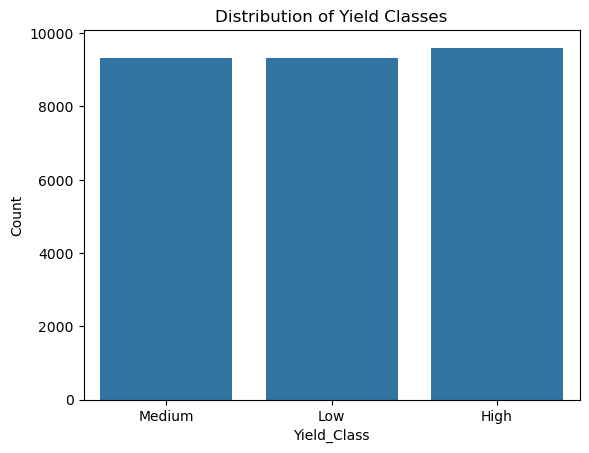

In [177]:
sns.countplot(x='Yield_Class', data=merged_df)
plt.title('Distribution of Yield Classes')
plt.xlabel('Yield_Class')
plt.ylabel('Count')
plt.show()

ALL THREE CLASSES ARE HIGHLY BALANCED.

In [178]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 28248 entries, 0 to 28247
,Data columns (total 8 columns):
, #   Column                                           Non-Null Count  Dtype  
,---  ------                                           --------------  -----  
, 0   Area                                             28248 non-null  object 
, 1   Year                                             28248 non-null  int64  
, 2   Item                                             28248 non-null  object 
, 3   Yield (hg/ha)                                    28248 non-null  int64  
, 4   average_rain_fall_mm_per_year                    28248 non-null  float64
, 5   avg_temp                                         28248 non-null  float64
, 6   Pesticide Quantity(Tonnes of Active Ingredients  28248 non-null  float64
, 7   Yield_Class                                      28248 non-null  object 
,dtypes: float64(3), int64(2), object(3)
,memory usage: 1.7+ MB


In [183]:
merged_df = merged_df.rename(columns={
    'average_rain_fall_mm_per_year'     : 'rainfall',
    'avg_temp'            : 'temperature',
    'Pesticide Quantity(Tonnes of Active Ingredients' : 'pesticides',
    'Yield_Class'     : 'Yield_Class' 
})

In [186]:
# Feature-Target split
X = merged_df[['rainfall', 'temperature', 'pesticides']]
y = merged_df['Yield_Class']

In [193]:
# Safety check to remove any null values if left
X = X.dropna()
y = merged_df.loc[X.index, 'Yield_Class'] 

In [323]:
merged_df.groupby(['Area','Item'], sort=True)['Yield (hg/ha)'].sum().nlargest(10)

Area            Item          
India           Cassava           133475892
                Potatoes           85089642
United Kingdom  Potatoes           46705145
Australia       Potatoes           45670386
Mexico          Potatoes           42053880
India           Sweet potatoes     40850986
Mexico          Sweet potatoes     35808592
Australia       Sweet potatoes     35550294
Pakistan        Potatoes           32969754
Turkey          Potatoes           30530955
Name: Yield (hg/ha), dtype: int64

## Model Building 

#### Train-test split
- test_size(0.2) tells 20% data for testing, 80% for training
- random state(42) ensures consistent data splitting

In [188]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

##### We do not need features standardiztion because Random forest model is based on Based on threshold-based splits, not distance

#### Random Forest Classification

In [190]:
merged_df.shape

(28248, 8)

for Medium to large dataset (e.g. 1000–50,000 rows), estimator = 100 is efficient 

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support
,
,        High       0.26      0.26      0.26      1890
,         Low       0.36      0.39      0.38      1826
,      Medium       0.32      0.29      0.30      1934
,
,    accuracy                           0.31      5650
,   macro avg       0.31      0.31      0.31      5650
,weighted avg       0.31      0.31      0.31      5650
,


In [194]:

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [196]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [202]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)  # use transform only, not fit_transform

# Now y_train_encoded and y_test_encoded are numerical: e.g., ['Low', 'Medium', 'High'] -> [1, 2, 0]

In [203]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Your train-test split assumed:
# X_train, X_test, y_train, y_test already defined

def compare_models(model):
    model_name = model.__class__.__name__
    model.fit(X_train, y_train_encoded)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    return [model_name, accuracy]

# List of classification models
models = [
    GradientBoostingClassifier(n_estimators=200, max_depth=3, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    SVC(),
    DecisionTreeClassifier(),
    XGBClassifier(n_estimators=200, max_depth=3, random_state=0)
]

# Evaluate models
model_results = list(map(compare_models, models))

# Print results
print(*model_results, sep="\n")


['GradientBoostingClassifier', 0.46749262536873154]
,['RandomForestClassifier', 0.4279646017699115]
,['SVC', 0.4306784660766962]
,['DecisionTreeClassifier', 0.31268436578171094]
,['XGBClassifier', 0.4586430678466077]


In [207]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=200, max_depth=3, random_state=0)
gb_model.fit(X_train, y_train_encoded)

# Predict on test set
y_pred = gb_model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:\n", cm)

# Optional: Classification Report
print("Classification Report:\n", classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.46749262536873154
,Confusion Matrix:
, [[1378  746  719]
, [ 866 1525  381]
, [ 980  821 1059]]


NameError: name 'label_encoder' is not defined

<Axes: >

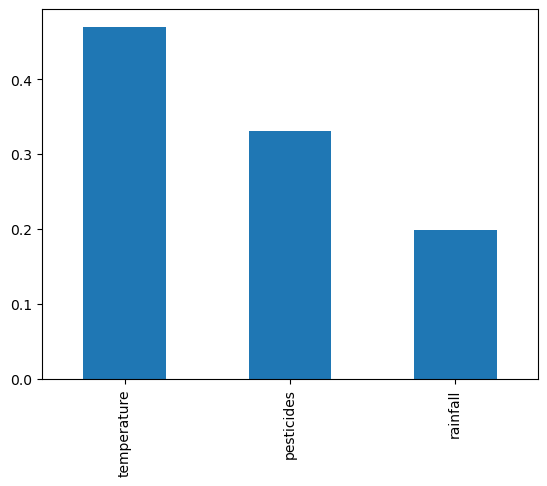

In [346]:
# Checking if the input features are predictive enough
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar')

Temperature and Pesticides are more predictive features accoring to this dataset for yield

In [328]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
,Index: 24164 entries, 0 to 28247
,Data columns (total 8 columns):
, #   Column         Non-Null Count  Dtype  
,---  ------         --------------  -----  
, 0   Area           24164 non-null  object 
, 1   Year           24164 non-null  int64  
, 2   Item           24164 non-null  object 
, 3   Yield (hg/ha)  24164 non-null  int64  
, 4   rainfall       24158 non-null  float64
, 5   temperature    24164 non-null  float64
, 6   pesticides     24164 non-null  float64
, 7   Yield_Class    24164 non-null  object 
,dtypes: float64(3), int64(2), object(3)
,memory usage: 1.7+ MB


In [347]:
missing_percent = (merged_df.isnull().sum() / len(merged_df)) * 100
print(missing_percent)

Area             0.0
,Year             0.0
,Item             0.0
,Yield (hg/ha)    0.0
,rainfall         0.0
,temperature      0.0
,pesticides       0.0
,Yield_Class      0.0
,dtype: float64


In [104]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
,Index: 27686 entries, 0 to 28247
,Data columns (total 8 columns):
, #   Column         Non-Null Count  Dtype  
,---  ------         --------------  -----  
, 0   Area           27686 non-null  object 
, 1   Year           27686 non-null  int64  
, 2   Item           27686 non-null  object 
, 3   Yield (hg/ha)  27686 non-null  int64  
, 4   rainfall       27686 non-null  float64
, 5   temperature    27686 non-null  float64
, 6   pesticides     27686 non-null  float64
, 7   Yield_Class    27686 non-null  object 
,dtypes: float64(3), int64(2), object(3)
,memory usage: 1.9+ MB


##### 47% accuracy with XGB CLassifier

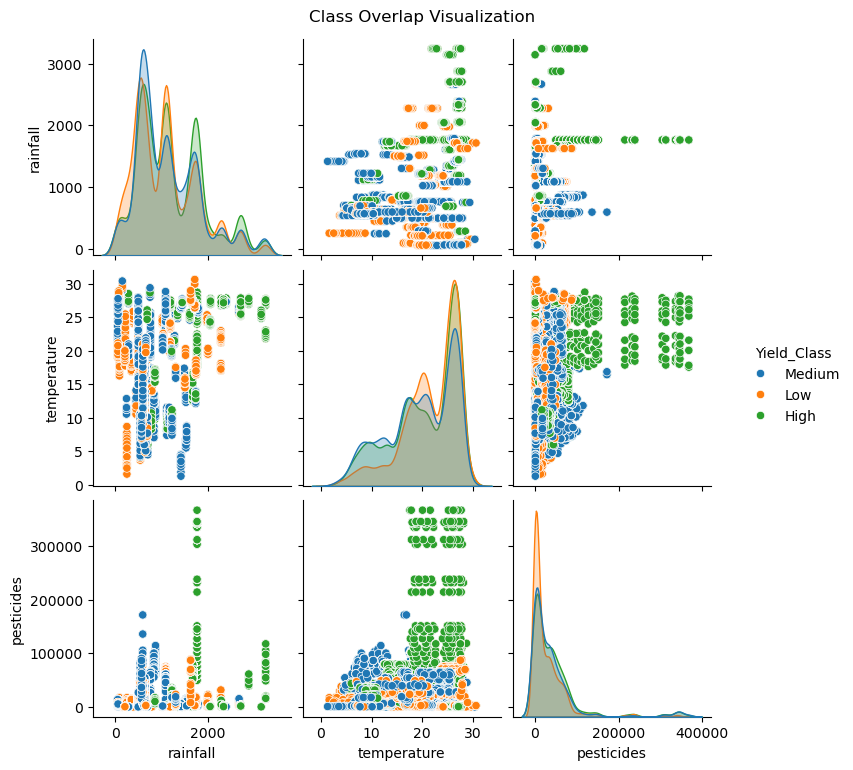

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt

X_plot = X.copy()
X_plot['Yield_Class'] = y  # original string labels

sns.pairplot(X_plot, hue='Yield_Class', diag_kind='kde')
plt.suptitle("Class Overlap Visualization", y=1.02)
plt.show()

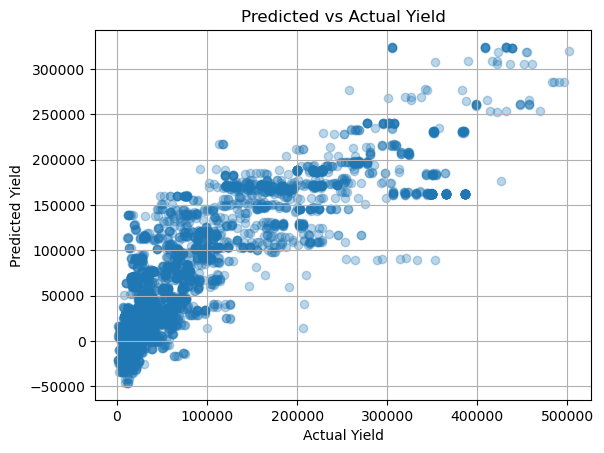

In [361]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield")
plt.grid(True)
plt.show()
